### 3 Visualization - Prediction Confidence Heatmaps

A sliding window approach was applied on the whole slide images (WSIs) with the trained CNN model to generate confidence heatmaps. 

The WSIs were tiled into 1536 x 1536 images patches in the prepocessing steps. A sliding window approached was applied on evey image patch of a WSI. At each time, the CNN model took a 256x256 pixels region as input, forward propagated and generated a prediction score for cored plaque, diffuse plaque and CAA respectively. By systematically sliding the input region across the entire 1536 x 1536 image patch, the prediction scores were saved and ploted as prediction confidence heatmap for this patch. The heatmap for the WSI was obtained by doing this on all image patches of it.

In [1]:
import time, os, glob

import torch
torch.manual_seed(123456789)
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib
matplotlib.use('PDF')   # for heatmap with original
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from tqdm import tqdm
import copy

In [2]:
IMG_DIR  = 'data/norm_tiles/'
MODEL_DIR = 'models/CNN_model_parameters.pkl'
SAVE_DIR = 'data/outputs/heatmaps/'

In [7]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [8]:
img_size = 1536
stride = 16
batch_size = 64
num_workers = 16

norm = np.load('utils/normalization.npy', allow_pickle=True).item()
normalize = transforms.Normalize(norm['mean'], norm['std'])
to_tensor = transforms.ToTensor()
use_gpu = torch.cuda.is_available()

filenames = glob.glob(IMG_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]
print(filenames)

['NA3777-02_AB', 'NA4077-02_AB', 'NA4092-02_AB', 'NA4107-02_AB', 'NA4160-02_AB', 'NA4195-02_AB', 'NA4256-02_AB', 'NA4299-02_AB', 'NA4391-02_AB', 'NA4450-02_AB', 'NA4463-02_AB', 'NA4471-02_AB', 'NA4553-02_AB', 'NA4626-02_AB', 'NA4672-02_AB', 'NA4675-02_AB', 'NA4691-02_AB', 'NA4695-02_AB']


In [6]:
from torch.utils.data import Dataset

class HeatmapDataset(Dataset):
    def __init__(self, tile_dir, row, col, stride=1):
        """
        Args:
            tile_dir (string): path to the folder where tiles are
            row (int): row index of the tile being operated
            col (int): column index of the tile being operated
            stride: stride of sliding 
        """
        self.tile_size = 256
        self.img_size = 1536
        self.stride = stride
        padding = 128
        large_img = torch.ones(3, 3*self.img_size, 3*self.img_size)
        
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                img_path = tile_dir+'/'+str(row+i)+'/'+str(col+j)+'.jpg'
                try:
                    img = Image.open(img_path)
                    img = transforms.ToTensor()(img) 
                except:
                    img = torch.ones(3,self.img_size, self.img_size)
                
                large_img[:, (i+1)*self.img_size:(i+2)*self.img_size,(j+1)*self.img_size:(j+2)*self.img_size] = img
        
        large_img = normalize(large_img)
        
        self.padding_img = large_img[:,self.img_size-padding:2*self.img_size+padding, self.img_size-padding:2*self.img_size+padding]
        self.len = (self.img_size//self.stride)**2
        
    def __getitem__(self, index):

        row = (index*self.stride // self.img_size)*self.stride
        col = (index*self.stride % self.img_size)

        img = self.padding_img[:, row:row+self.tile_size, col:col+self.tile_size]        
    
        return img

    def __len__(self):
        return self.len

In [7]:
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()
        
    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [8]:
# instatiate the model
model = torch.load(MODEL_DIR, map_location=lambda storage, loc: storage)

if use_gpu:
    model = model.module.cuda()
else:
    model = model.module

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribut

In [9]:
for filename in filenames:
    TILE_DIR = IMG_DIR+'{}/0/'.format(filename)

    imgs = []
    for target in sorted(os.listdir(TILE_DIR)):
        d = os.path.join(TILE_DIR, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if fname.endswith('.jpg'):
                    path = os.path.join(root, fname)
                    imgs.append(path)

    rows = [int(image.split('/')[-2]) for image in imgs]
    row_nums = max(rows) + 1
    cols = [int(image.split('/')[-1].split('.')[0]) for image in imgs]
    col_nums = max(cols) +1    
    
    heatmap_res = img_size // stride
    final_output = np.zeros((3, heatmap_res*row_nums, heatmap_res*col_nums))

    model.train(False)  # Set model to evaluate mode

    for row in tqdm(range(row_nums)):
        for col in range(col_nums):

            image_datasets = HeatmapDataset(TILE_DIR, row, col, stride=stride)
            dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                                 shuffle=False, num_workers=num_workers)

            running_preds = torch.Tensor(0)
            for data in dataloader:
                # get the inputs
                inputs = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(), volatile=True)
                    # forward
                    outputs = model(inputs)
                    preds = F.sigmoid(outputs) #posibility for each class
                    preds = preds.data.cpu()
                    running_preds = torch.cat([running_preds, preds])

            cored = np.asarray(running_preds[:,0]).reshape(img_size//stride,img_size//stride)
            diffuse = np.asarray(running_preds[:,1]).reshape(img_size//stride,img_size//stride)
            caa = np.asarray(running_preds[:,2]).reshape(img_size//stride,img_size//stride)

            final_output[0, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = cored
            final_output[1, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = diffuse
            final_output[2, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = caa

    np.save(SAVE_DIR+filename, final_output)

100%|██████████| 28/28 [3:20:25<00:00, 428.30s/it]  


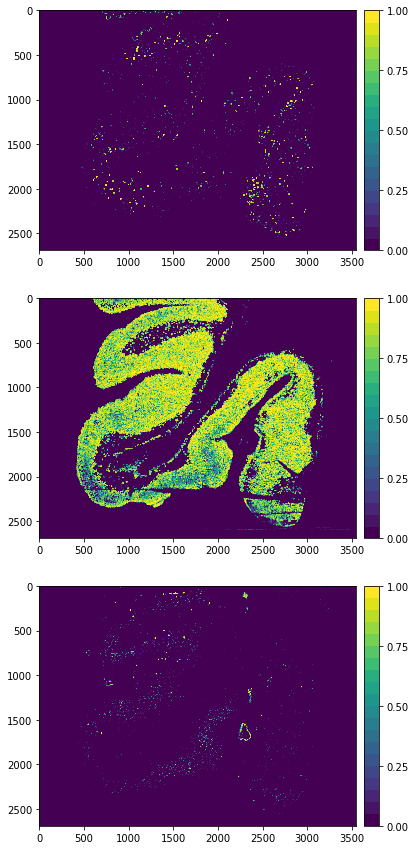

In [10]:
fig = plt.figure(figsize=(45,15))
    
ax = fig.add_subplot(311)

im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

ax = fig.add_subplot(312)

im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

ax = fig.add_subplot(313)

im = ax.imshow(final_output[2], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

In [3]:
# Save Heatmaps to Image Files
SAVE_PNG_DIR = 'data/outputs/heatmaps_png/'
if not os.path.exists(SAVE_PNG_DIR):
        os.makedirs(SAVE_PNG_DIR)

filenames = glob.glob(SAVE_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]

t = tqdm(total=len(filenames))
for i, filename in enumerate(filenames):
    # heatmaps[0] = cored, heatmaps[1] = diffuse, heatmaps[2] = caa
    heatmaps = np.load(SAVE_DIR+filename)
    t.set_description_str("Image " + str(i) + " shape: " + str(heatmaps.shape))
    t.refresh()
    t.write("", end=' ')
    
    fig = plt.figure(figsize=(45,15), dpi=1200)

    ax = fig.add_subplot(311, title="Cored")
    im = plt.imshow(heatmaps[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    ax.set_axis_off()
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(312, title="Diffuse")
    im = plt.imshow(heatmaps[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    ax.set_axis_off()
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(313, title="CAA")
    im = plt.imshow(heatmaps[2], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    ax.set_axis_off()
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    fig.savefig(SAVE_PNG_DIR+filename.split('.')[0]+'.png', dpi=fig.dpi, bbox_inches='tight')
    plt.close(fig)
    t.update()
t.close()

Image 0 shape: (3, 2976, 3456):   0%|          | 0/18 [00:00<?, ?it/s]

Image 1 shape: (3, 2976, 4608):   6%|▌         | 1/18 [01:49<30:55, 109.14s/it]

Image 2 shape: (3, 2880, 4128):  11%|█         | 2/18 [03:45<29:30, 110.66s/it]

Image 3 shape: (3, 2304, 4320):  17%|█▋        | 3/18 [05:37<27:49, 111.33s/it]

Image 4 shape: (3, 2688, 3744):  22%|██▏       | 4/18 [07:29<25:57, 111.26s/it]

Image 5 shape: (3, 2496, 3552):  28%|██▊       | 5/18 [09:19<24:03, 111.02s/it]

Image 6 shape: (3, 2976, 3936):  33%|███▎      | 6/18 [11:09<22:08, 110.71s/it]

Image 7 shape: (3, 2784, 3648):  39%|███▉      | 7/18 [12:56<20:06, 109.64s/it]

Image 8 shape: (3, 2976, 3168):  44%|████▍     | 8/18 [14:42<18:05, 108.53s/it]

Image 9 shape: (3, 2976, 3648):  50%|█████     | 9/18 [16:26<16:02, 106.99s/it]

Image 10 shape: (3, 2880, 3456):  56%|█████▌    | 10/18 [18:11<14:11, 106.41s/it]

Image 11 shape: (3, 2304, 4320):  61%|██████    | 11/18 [19:54<12:18, 105.54s/it]

Image 12 shape: (3, 2976, 4320):  67%|██████▋   | 12/18 [21:45<10:42, 107.12s/it]

Image 13 shape: (3, 2688, 3072):  72%|███████▏  | 13/18 [23:33<08:58, 107.61s/it]

Image 14 shape: (3, 2304, 3168):  78%|███████▊  | 14/18 [25:17<07:06, 106.58s/it]

Image 15 shape: (3, 2880, 3456):  83%|████████▎ | 15/18 [27:07<05:22, 107.48s/it]

Image 16 shape: (3, 2592, 3456):  89%|████████▉ | 16/18 [28:56<03:35, 107.88s/it]

Image 17 shape: (3, 2688, 3552):  94%|█████████▍| 17/18 [30:45<01:48, 108.53s/it]

Image 17 shape: (3, 2688, 3552): 100%|██████████| 18/18 [32:32<00:00, 108.35s/it]


In [3]:
# Save Original Slides to Image Files by loading norm_tiles
SAVE_ORIG_DIR = 'data/outputs/original_png/'
if not os.path.exists(SAVE_ORIG_DIR):
    os.makedirs(SAVE_ORIG_DIR)
        
filenames = glob.glob(IMG_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]
img_size = 1536

t = tqdm(total=len(filenames))
for i, filename in enumerate(filenames):
    # Get image dimension
    TILE_DIR = IMG_DIR+'{}/0/'.format(filename)
    imgs = []
    for target in sorted(os.listdir(TILE_DIR)):
        d = os.path.join(TILE_DIR, target)
        if not os.path.isdir(d):
            continue
        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if fname.endswith('.jpg'):
                    path = os.path.join(root, fname)
                    imgs.append(path)
                    
    rows = [int(image.split('/')[-2]) for image in imgs]
    row_nums = max(rows) + 1
    cols = [int(image.split('/')[-1].split('.')[0]) for image in imgs]
    col_nums = max(cols) + 1
    width = col_nums*img_size
    height = row_nums*img_size
    
    t.set_description_str("Image " + str(i) + ': ({}, {}) ({}, {})'.format(col_nums, row_nums, width, height))
    t.refresh()
    t.write("", end=' ')
    
    # Generate WSI
    orig_img = Image.new('RGB', (width, height))
    for r in range(row_nums):
        for c in range(col_nums):
            img_path = TILE_DIR + '{}/{}.jpg'.format(r, c)
            img = Image.open(img_path)
            orig_img.paste(img, (c*img_size, r*img_size))

    orig_img.save(SAVE_ORIG_DIR+filename+'.png')
    
    t.update()
t.close()

Image 0: (36, 31) (55296, 47616):   0%|          | 0/18 [00:00<?, ?it/s]

Image 1: (48, 31) (73728, 47616):   6%|▌         | 1/18 [08:04<2:17:17, 484.58s/it]

Image 2: (43, 30) (66048, 46080):  11%|█         | 2/18 [20:42<2:31:03, 566.48s/it]

Image 3: (45, 24) (69120, 36864):  17%|█▋        | 3/18 [30:49<2:24:37, 578.52s/it]

Image 4: (39, 28) (59904, 43008):  22%|██▏       | 4/18 [38:50<2:08:13, 549.54s/it]

Image 5: (37, 26) (56832, 39936):  28%|██▊       | 5/18 [46:53<1:54:41, 529.33s/it]

Image 6: (41, 31) (62976, 47616):  33%|███▎      | 6/18 [54:40<1:42:10, 510.86s/it]

Image 7: (38, 29) (58368, 44544):  39%|███▉      | 7/18 [1:06:09<1:43:25, 564.15s/it]

Image 8: (33, 31) (50688, 47616):  44%|████▍     | 8/18 [1:15:32<1:33:59, 563.93s/it]

Image 9: (38, 31) (58368, 47616):  50%|█████     | 9/18 [1:23:37<1:21:01, 540.15s/it]

Image 10: (36, 30) (55296, 46080):  56%|█████▌    | 10/18 [1:32:01<1:10:34, 529.31s/it]

Image 11: (45, 24) (69120, 36864):  61%|██████    | 11/18 [1:40:36<1:01:16, 525.16s/it]

Image 12: (45, 31) (69120, 47616):  67%|██████▋   | 12/18 [1:49:34<52:54, 529.01s/it]  

Image 13: (32, 28) (49152, 43008):  72%|███████▏  | 13/18 [1:59:12<45:17, 543.54s/it]

Image 14: (33, 24) (50688, 36864):  78%|███████▊  | 14/18 [2:06:07<33:39, 504.97s/it]

Image 15: (36, 30) (55296, 46080):  83%|████████▎ | 15/18 [2:12:04<23:01, 460.48s/it]

Image 16: (36, 27) (55296, 41472):  89%|████████▉ | 16/18 [2:19:59<15:29, 464.87s/it]

Image 17: (37, 28) (56832, 43008):  94%|█████████▍| 17/18 [2:26:56<07:30, 450.68s/it]

Image 17: (37, 28) (56832, 43008): 100%|██████████| 18/18 [2:34:22<00:00, 449.17s/it]


In [3]:
# Save Heatmaps with originals to Image Files
import pyvips as Vips

# map vips formats to np dtypes
format_to_dtype = {
    'uchar': np.uint8,
    'char': np.int8,
    'ushort': np.uint16,
    'short': np.int16,
    'uint': np.uint32,
    'int': np.int32,
    'float': np.float32,
    'double': np.float64,
    'complex': np.complex64,
    'dpcomplex': np.complex128,
}

# vips image to numpy array
def vips2numpy(vi):
    return np.ndarray(buffer=vi.write_to_memory(),
                      dtype=format_to_dtype[vi.format],
                      shape=[vi.height, vi.width, vi.bands])

ORIG_DIR = 'data/box/'
SAVE_PNG_DIR = 'data/outputs/heatmaps_original_png/'
if not os.path.exists(SAVE_PNG_DIR):
        os.makedirs(SAVE_PNG_DIR)

filenames = glob.glob(IMG_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]

t = tqdm(total=len(filenames))
for i, filename in enumerate(filenames):
    if i <= 15:
        t.update()
        continue
    # heatmaps[0] = cored, heatmaps[1] = diffuse, heatmaps[2] = caa
    heatmaps = np.load(SAVE_DIR+filename+'.npy')
    
    # Load original slide image
    vips_img = Vips.Image.new_from_file(ORIG_DIR+filename+'.svs', level=0)
    vips_img = vips_img.resize(0.4)   # Resize by 2x
    orig_img = vips2numpy(vips_img)
    
    t.set_description_str("Image " + str(i) + " shape: " + str(orig_img.shape) + " heatmap: " + str(heatmaps.shape))
    t.refresh()
    t.write("", end=' ')
    
    # For scale: 60, 15, 1200
    fig = plt.figure(figsize=(90,22.5), dpi=4800)

    ax = fig.add_subplot(411, title=filename)
    plt.imshow(orig_img)
    ax.set_axis_off()
    
    ax = fig.add_subplot(412, title="Cored")
    im = plt.imshow(heatmaps[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    ax.set_axis_off()
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(413, title="Diffuse")
    im = plt.imshow(heatmaps[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    ax.set_axis_off()
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(414, title="CAA")
    im = plt.imshow(heatmaps[2], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    ax.set_axis_off()
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    fig.savefig(SAVE_PNG_DIR+filename+'.pdf', dpi=fig.dpi, bbox_inches='tight')
    
    plt.close(fig)
    t.update()
t.close()

# Command to convert pdf to png
# pdftoppm NA3777-02_AB.pdf NA3777-02_AB -png -r 2600

Image 16 shape: (16429, 21514, 4) heatmap: (3, 2592, 3456):  89%|████████▉ | 16/18 [00:51<00:06,  3.23s/it]

Image 17 shape: (16654, 22310, 4) heatmap: (3, 2688, 3552):  94%|█████████▍| 17/18 [11:24<00:35, 35.05s/it]

Image 17 shape: (16654, 22310, 4) heatmap: (3, 2688, 3552): 100%|██████████| 18/18 [20:35<00:00, 216.39s/it]


In [87]:
# Obtain CNN results and calculate a rough density
import xml.etree.ElementTree as ET
import csv
import pandas as pd

SAVE_CSV_DIR = 'data/outputs/heatmaps_csv/'
if not os.path.exists(SAVE_CSV_DIR):
    os.makedirs(SAVE_CSV_DIR)
SAVE_CSV_FILE = SAVE_CSV_DIR + 'Plaque Density.csv'

# Threshold for CNN prediction probability
threshold = 0.9

filenames = glob.glob(IMG_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]

# Initialize csv file
data_fields = [['imagename',
                'width',
                'height',
                'area',
                'threshold',
                '# of cored',
                '# of diffuse',
                '# of caa'
                'density of cored',
                'density of diffuse',
                'density of caa']]

with open(SAVE_CSV_FILE, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data_fields)

t = tqdm(total=len(filenames))
for i, filename in enumerate(filenames):
    # Get WSI dimension
    XML_DIR = IMG_DIR+'{}/{}/vips-properties.xml'.format(filename, filename)
    tree = ET.parse(XML_DIR)
    root = tree.getroot()
    width = int(root[0][0][1].text)
    height = int(root[0][1][1].text)
    area = width * height
    
    # Get CNN results
    heatmaps = np.load(SAVE_DIR+filename+'.npy')
    cored = heatmaps[0]
    diffuse = heatmaps[1]
    caa = heatmaps[2]
    
    cored_count = cored[np.where(cored > threshold)].size
    diffuse_count = diffuse[np.where(diffuse > threshold)].size
    caa_count = caa[np.where(caa > threshold)].size
    
    # Calculate density
    d_cored = cored_count / area * 1e6
    d_diffuse = diffuse_count / area * 1e6
    d_caa = caa_count / area * 1e6

    data = [[filename, width, height, area, threshold, cored_count, diffuse_count, caa_count, d_cored, d_diffuse, d_caa]]
    
    with open(SAVE_CSV_FILE, 'a') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)
    t.update()
t.close()

# Print out csv
csv_reader = pd.read_csv(SAVE_CSV_FILE)
csv_reader.sort_values('density of diffuse', ascending = False)

100%|██████████| 18/18 [00:03<00:00,  6.16it/s]


imagename  width  height        area  threshold  # of cored  \
0   NA3777-02_AB  53784   47177  2537367768        0.9        6502   
4   NA4160-02_AB  59760   41787  2497191120        0.9       31019   
17  NA4695-02_AB  55776   41634  2322177984        0.9       25421   
9   NA4450-02_AB  57768   47481  2742882408        0.9       31120   
6   NA4256-02_AB  61752   46410  2865910320        0.9       32176   
7   NA4299-02_AB  57768   43740  2526772320        0.9       70000   
3   NA4107-02_AB  67728   36459  2469295152        0.9       31850   
8   NA4391-02_AB  49800   47520  2366496000        0.9       24189   
16  NA4691-02_AB  53784   41073  2209070232        0.9       13423   
15  NA4675-02_AB  53784   45548  2449753632        0.9      100957   
14  NA4672-02_AB  49800   36131  1799323800        0.9       71885   
1   NA4077-02_AB  73704   46200  3405124800        0.9       50562   
5   NA4195-02_AB  55776   39849  2222617824        0.9        6617   
2   NA4092-02_AB  65736   45178  2969821008        0.9       43717   
12  NA4553-02_AB  67728   47200  3196761600        0.9       32290   
11  NA4471-02_AB  67728   36791  2491780848        0.9        3242   
13  NA4626-02_AB  47808   41668  1992063744        0.9       38096   
10  NA4463-02_AB  53784   45142  2427917328        0.9           0   

    # of diffuse  # of caa  density of cored  density of diffuse  \
0        2042399      1897          2.562498          804.928251   
4        1478413      3557         12.421556          592.030377   
17       1002352      6624         10.947051          431.643055   
9        1136806       552         11.345729          414.456703   
6        1113128    143560         11.227148          388.402942   
7         940190       974         27.703327          372.091301   
3         902238       462         12.898418          365.382809   
8         792054      6627         10.221441          334.694840   
16        529613      5462          6.076312          239.744754   
15        537865      3730         41.211083          219.558813   
14        322276      1254         39.951119          179.109508   
1         467148      3526         14.848795          137.189685   
5         253929      6742          2.977120          114.247712   
2         243351      8578         14.720416           81.941302   
12        231936     63975         10.100847           72.553424   
11         70384      4354          1.301078           28.246465   
13         31983      1649         19.123886           16.055209   
10             0        14          0.000000            0.000000   

    density of caa  
0         0.747625  
4         1.424400  
17        2.852495  
9         0.201248  
6        50.092286  
7         0.385472  
3         0.187098  
8         2.800343  
16        2.472533  
15        1.522602  
14        0.696928  
1         1.035498  
5         3.033360  
2         2.888390  
12       20.012440  
11        1.747345  
13        0.827785  
10        0.005766